## Libraries and Dependencies

In [89]:
import torch
from matplotlib import pyplot as plt
import numpy as np
from collections import OrderedDict
from pyDOE import lhs
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

In [90]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## PINNs

In [91]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [92]:
# the physics-guided neural network
class PINNs():
    def __init__(self, X_u, u, X_f, layers, alpha):
        # data
        self.x_u = torch.tensor(
            X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(
            X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(
            X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(
            X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.alpha = alpha

        # deep neural networks
        self.dnn = DNN(layers).to(device)

        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )

        self.iter = 0
    
    def net_u(self, x, t):
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        f = u_t - self.alpha * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss

    def train(self):
        self.dnn.train()

        # Backward and optimize
        self.optimizer.step(self.loss_func)

            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f



## Configuration

In [93]:
alpha = 1.0
T_i = 0.0
T_t = 1.0
T_b = 0.0

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

N_t = 256
N_x = 256
t = np.linspace(0, 1, N_t)
x = np.linspace(-1, 1, N_x)

X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) # Left boundary, t=0
uu1 = np.ones_like(xx1) * T_i
xx2 = np.hstack((X[:,0:1], T[:,0:1])) # Lower boundary, x=-1
uu2 = np.ones_like(xx2) * T_b
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # Upper boundary, x=1
uu3 = np.ones_like(xx3) * T_t

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [94]:
print(np.shape(xx2))

(256, 2)


## Training

In [95]:
model = PINNs(X_u_train, u_train, X_f_train, layers, alpha)

In [96]:
%%time

model.train()

Iter 100, Loss: 1.50001e-02, Loss_u: 1.28013e-02, Loss_f: 2.19872e-03
Iter 200, Loss: 1.18846e-02, Loss_u: 1.12284e-02, Loss_f: 6.56174e-04
Iter 300, Loss: 1.07596e-02, Loss_u: 1.03451e-02, Loss_f: 4.14515e-04
Iter 400, Loss: 9.89087e-03, Loss_u: 9.57550e-03, Loss_f: 3.15368e-04
Iter 500, Loss: 8.67839e-03, Loss_u: 8.14513e-03, Loss_f: 5.33259e-04
Iter 600, Loss: 7.89464e-03, Loss_u: 7.32420e-03, Loss_f: 5.70437e-04
Iter 700, Loss: 7.70987e-03, Loss_u: 7.30505e-03, Loss_f: 4.04824e-04
Iter 800, Loss: 7.40937e-03, Loss_u: 6.84751e-03, Loss_f: 5.61860e-04
Iter 900, Loss: 7.25482e-03, Loss_u: 6.78882e-03, Loss_f: 4.65994e-04
Iter 1000, Loss: 6.84343e-03, Loss_u: 6.45021e-03, Loss_f: 3.93214e-04
Iter 1100, Loss: 6.70252e-03, Loss_u: 6.35104e-03, Loss_f: 3.51476e-04
Iter 1200, Loss: 6.60628e-03, Loss_u: 6.26115e-03, Loss_f: 3.45130e-04
Iter 1300, Loss: 6.47462e-03, Loss_u: 6.10767e-03, Loss_f: 3.66950e-04
Iter 1400, Loss: 6.42697e-03, Loss_u: 6.10516e-03, Loss_f: 3.21804e-04
Iter 1500, Loss

In [97]:
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

## Visualizations

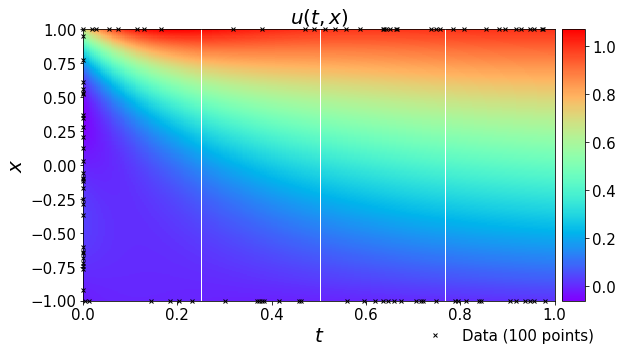

In [101]:

""" The aesthetic setting has changed. """

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    X_u_train[:,1], 
    X_u_train[:,0], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[64]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[128]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[196]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.show()

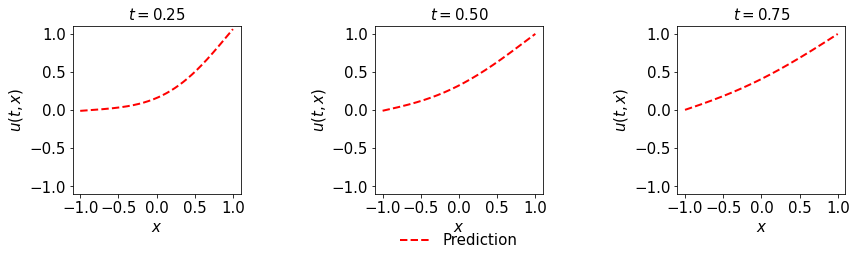

In [102]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])     
ax.plot(x,U_pred[64,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])    
ax.plot(x,U_pred[128,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])    
ax.plot(x,U_pred[196,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()